In [1]:
# Forecast the daily closing price of NVIDIA Corporation(NVDA)

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/NVDA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-09-08,134.589996,140.080002,133.690002,139.899994,139.814468,62487300
1,2022-09-09,141.570007,144.740005,141.259995,143.869995,143.782043,48661200
2,2022-09-12,143.690002,145.470001,141.979996,145.050003,144.961319,48415900
3,2022-09-13,138.020004,139.220001,130.990005,131.309998,131.229752,71495600
4,2022-09-14,132.539993,132.899994,129.130005,131.279999,131.199753,58850700


In [4]:
# Drop unnecessary fields
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df.head()

,Date,Close
0,2022-09-08,139.899994
1,2022-09-09,143.869995
2,2022-09-12,145.050003
3,2022-09-13,131.309998
4,2022-09-14,131.279999


In [5]:
total_set = df.shape[0]
print(f"Records: {df.shape[0]}")

Records: 251


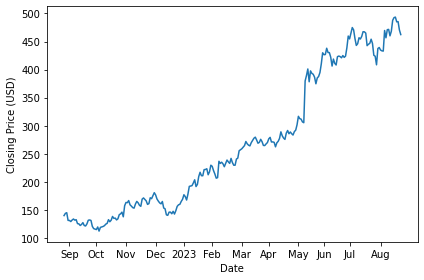

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['Sep', 'Oct', 'Nov', 'Dec', 2023, 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    )

plt.tight_layout()

In [7]:
# Test for stationarity - use augmented Dickey-Fuller (ADF) test
# If the test returns a p-value less than a certain significance level, typically 0.05 or 0.01, the series is stationary.

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'])

print(f"ADF Statistic :{adf_result[0]}")
print(f"P-Value :{adf_result[1]}")

ADF Statistic :0.040682579594916134
P-Value :0.9617699537358643


In [8]:
# Apply a first-order difference.

diff_close = np.diff(df['Close'], n=1)

In [9]:
# Test for stationarity - use augmented Dickey-Fuller (ADF) test

diff_adf_result = adfuller(diff_close)

print(f"ADF Statistic: {diff_adf_result[0]}")
print(f"P-value: {diff_adf_result[1]}")

ADF Statistic: -10.647099705992776
P-value: 4.764634574633495e-19


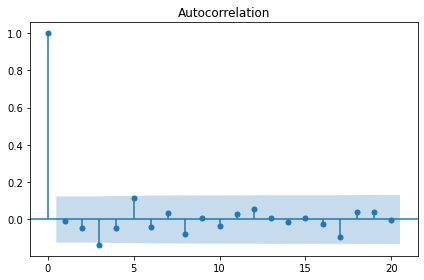

In [10]:
# Check for auto - correlation: measures the correlation between a variable and itself at a previous timestep (lag)
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(diff_close, lags=20)

plt.tight_layout()

In [11]:
# Split NVDA random walk into a train set containing the total entries minus 5.
# The remaining 5 days will be your test set.

test_nos = 5
train_nos = total_set - test_nos

train = df[:train_nos].copy()
test = df[train_nos:].copy()

In [12]:
# Forecast the last 5 days of the closing price using naive forecasting methods 
# 1. Forecasting the mean

mean = np.mean(train.Close)

test.loc[:, 'pred_mean'] = mean
test.head(6)

,Date,Close,pred_mean
246,2023-08-31,493.549988,261.493536
247,2023-09-01,485.089996,261.493536
248,2023-09-05,485.480011,261.493536
249,2023-09-06,470.609985,261.493536
250,2023-09-07,462.410004,261.493536


In [13]:
# 2. Forecasting the last value

last_value = train.iloc[-1].Close

test.loc[:, 'pred_last'] = last_value
test.head()

,Date,Close,pred_mean,pred_last
246,2023-08-31,493.549988,261.493536,492.640015
247,2023-09-01,485.089996,261.493536,492.640015
248,2023-09-05,485.480011,261.493536,492.640015
249,2023-09-06,470.609985,261.493536,492.640015
250,2023-09-07,462.410004,261.493536,492.640015


In [14]:
# 3. Drift method
# Slope of a straight line by dividing the change in the y-axis by the change in the x-axis

deltaX = train_nos - 1
deltaY = last_value - 0

drift = deltaY / deltaX
#print(drift)
x_vals = np.arange(train_nos, total_set, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift
test.head()

,Date,Close,pred_mean,pred_last,pred_drift
246,2023-08-31,493.549988,261.493536,492.640015,494.650791
247,2023-09-01,485.089996,261.493536,492.640015,496.661566
248,2023-09-05,485.480011,261.493536,492.640015,498.672342
249,2023-09-06,470.609985,261.493536,492.640015,500.683117
250,2023-09-07,462.410004,261.493536,492.640015,502.693893


In [15]:
# measure the MSE for the different naive forecasting methods
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

47622.52607618578 301.6544563804255 567.2671156952234


<BarContainer object of 3 artists>

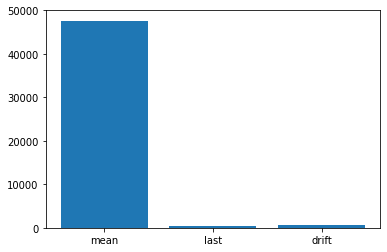

In [16]:
plt.bar(['mean', 'last', 'drift'], [mse_mean, mse_last, mse_drift])

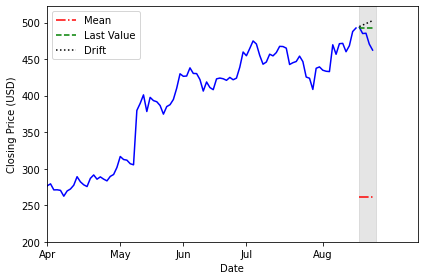

In [17]:
fig, ax = plt.subplots()

ax.plot(train.Date, train.Close, 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label="Mean")
ax.plot(test['pred_last'], 'g--', label="Last Value")
ax.plot(test['pred_drift'], 'k:', label="Drift")

ax.axvspan(train_nos, total_set, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['Sep', 'Oct', 'Nov', 'Dec', 2023, 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    )

ax.set_xlim(152,)
ax.set_ylim(200,)

plt.tight_layout()

In [18]:
# 4. Forecasting the next timestep
df_shift = df['Close'].shift(periods = 1)

df_shift.head()

0           NaN
1    139.899994
2    143.869995
3    145.050003
4    131.309998
Name: Close, dtype: float64

In [19]:
mse_one_step = mean_squared_error(test['Close'], df_shift[train_nos:])
print(mse_one_step)

72.1817977684109


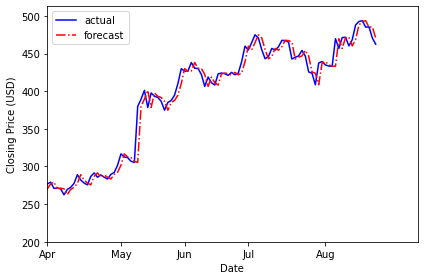

In [20]:
fig, ax = plt.subplots()


ax.plot(df['Date'], df['Close'], 'b-', label='actual')
ax.plot(df_shift, 'r-.', label="forecast")

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

plt.xticks(
            [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
           ['Sep', 'Oct', 'Nov', 'Dec', 2023, 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    )

ax.set_xlim(152,)
ax.set_ylim(200,)

plt.tight_layout()

In [21]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:00:10
